# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add LAVD folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/LAVD")

Wall time: 0 ns


# Overview

In the following notebok we visualize elliptic LCS in the Agulhas region from the AVISO dataset using the Lagrangian Averaged Vorticity Deviation (LAVD). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Lagrangian Averaged Vorticity Deviation (LAVD):

    * Compute trajectories launched from a regular meshgrid.
    
    * Compute the spin tensor along particle trajectories 
    
    \begin{equation}
    W(\mathbf{x}, t) = \begin{pmatrix} 0 && \mathbf{\omega}(\mathbf{x},t) \\ -\mathbf{\omega}(\mathbf{x},t) && 0 \end{pmatrix} = \dfrac{1}{2}(\nabla\mathbf{v}(\mathbf{x}, t)-\nabla \mathbf{v}(\mathbf{x}, t)^T).
    \end{equation}
    
    and then extract the vorticity $ \mathbf{\omega}(\mathbf{x},t) $ from the spin tensor.
    
    * Compute LAVD as:
    
    \begin{equation}
    \mathrm{LAVD}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i=0}^{N} | \mathbf{\omega}(\mathbf{x}(t_i), t) - \overline{\mathbf{\omega}(t)} |,
    \end{equation} where $ \overline{\mathbf{\omega}(t)} $ is the spatially averaged vorticity.
 <br />
6. Extract vortex boundaries from LAVD

# Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 110 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.05
dy = 0.05

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 0 ns


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

Wall time: 81.8 ms


# Lagrangian Averaged Vorticity Deviation ($ \mathrm{LAVD}$)

In [6]:
%%time
# Import package for computing trajectories/velocity
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for computing gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import package for LAVD
from ipynb.fs.defs.LAVD import _LAVD

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

def parallel_LAVD(i):
    
    # Define array (Nx, N) containing vorticity along a trajectory
    omega = np.zeros((X_domain.shape[1], len(time)))
    
    for j in range(omega.shape[0]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
            
        # only compute omega for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
    
            # compute velocity along trajectory
            Fmap = integration_dFdt(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]
        
            for t in range(len(time)):
        
                # compute gradient of velocity field
                grad_vel = gradient_velocity(time[t], Fmap[:,t], X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
            
                # compute spin tensor
                W = .5*(grad_vel-grad_vel.transpose())
                
                omega[j,t] = 2*W[0,1]
                
        else:
            
            omega[j, :] = np.nan
        
    return omega

Omega = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_LAVD)(i) for i in tqdm(range(X_domain.shape[0]))))

# compute LAVD from vorticity along trajectories
LAVD = _LAVD(Omega)

  0%|          | 0/161 [00:00<?, ?it/s]

Wall time: 2min 2s


# Vortex boundaries from LAVD

The vortex boundaries are extracted following the algorithm proposed in [1].

In [7]:
# Import package for computing outermost vortex boundary
from ipynb.fs.defs.find_outermost_contour import find_outermost_contour

# minimum distance between local maxima in the LAVD field
distance = 0.5

# resolution of LAVD field when extracting contours
n = 25

# convexity deficiency
c_d = 10**(-6)

# reject local maxima below this threshold
loc_threshold = 0.3

# minimum length of vortex boundary
l_min = 0.5

# find outermost contour satisfying the specifi conditions = estimated vortex boundary.
vortex = find_outermost_contour(X_domain, Y_domain, LAVD, distance, n, c_d, l_min, loc_threshold, Ncores)

  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1750s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.1s finished


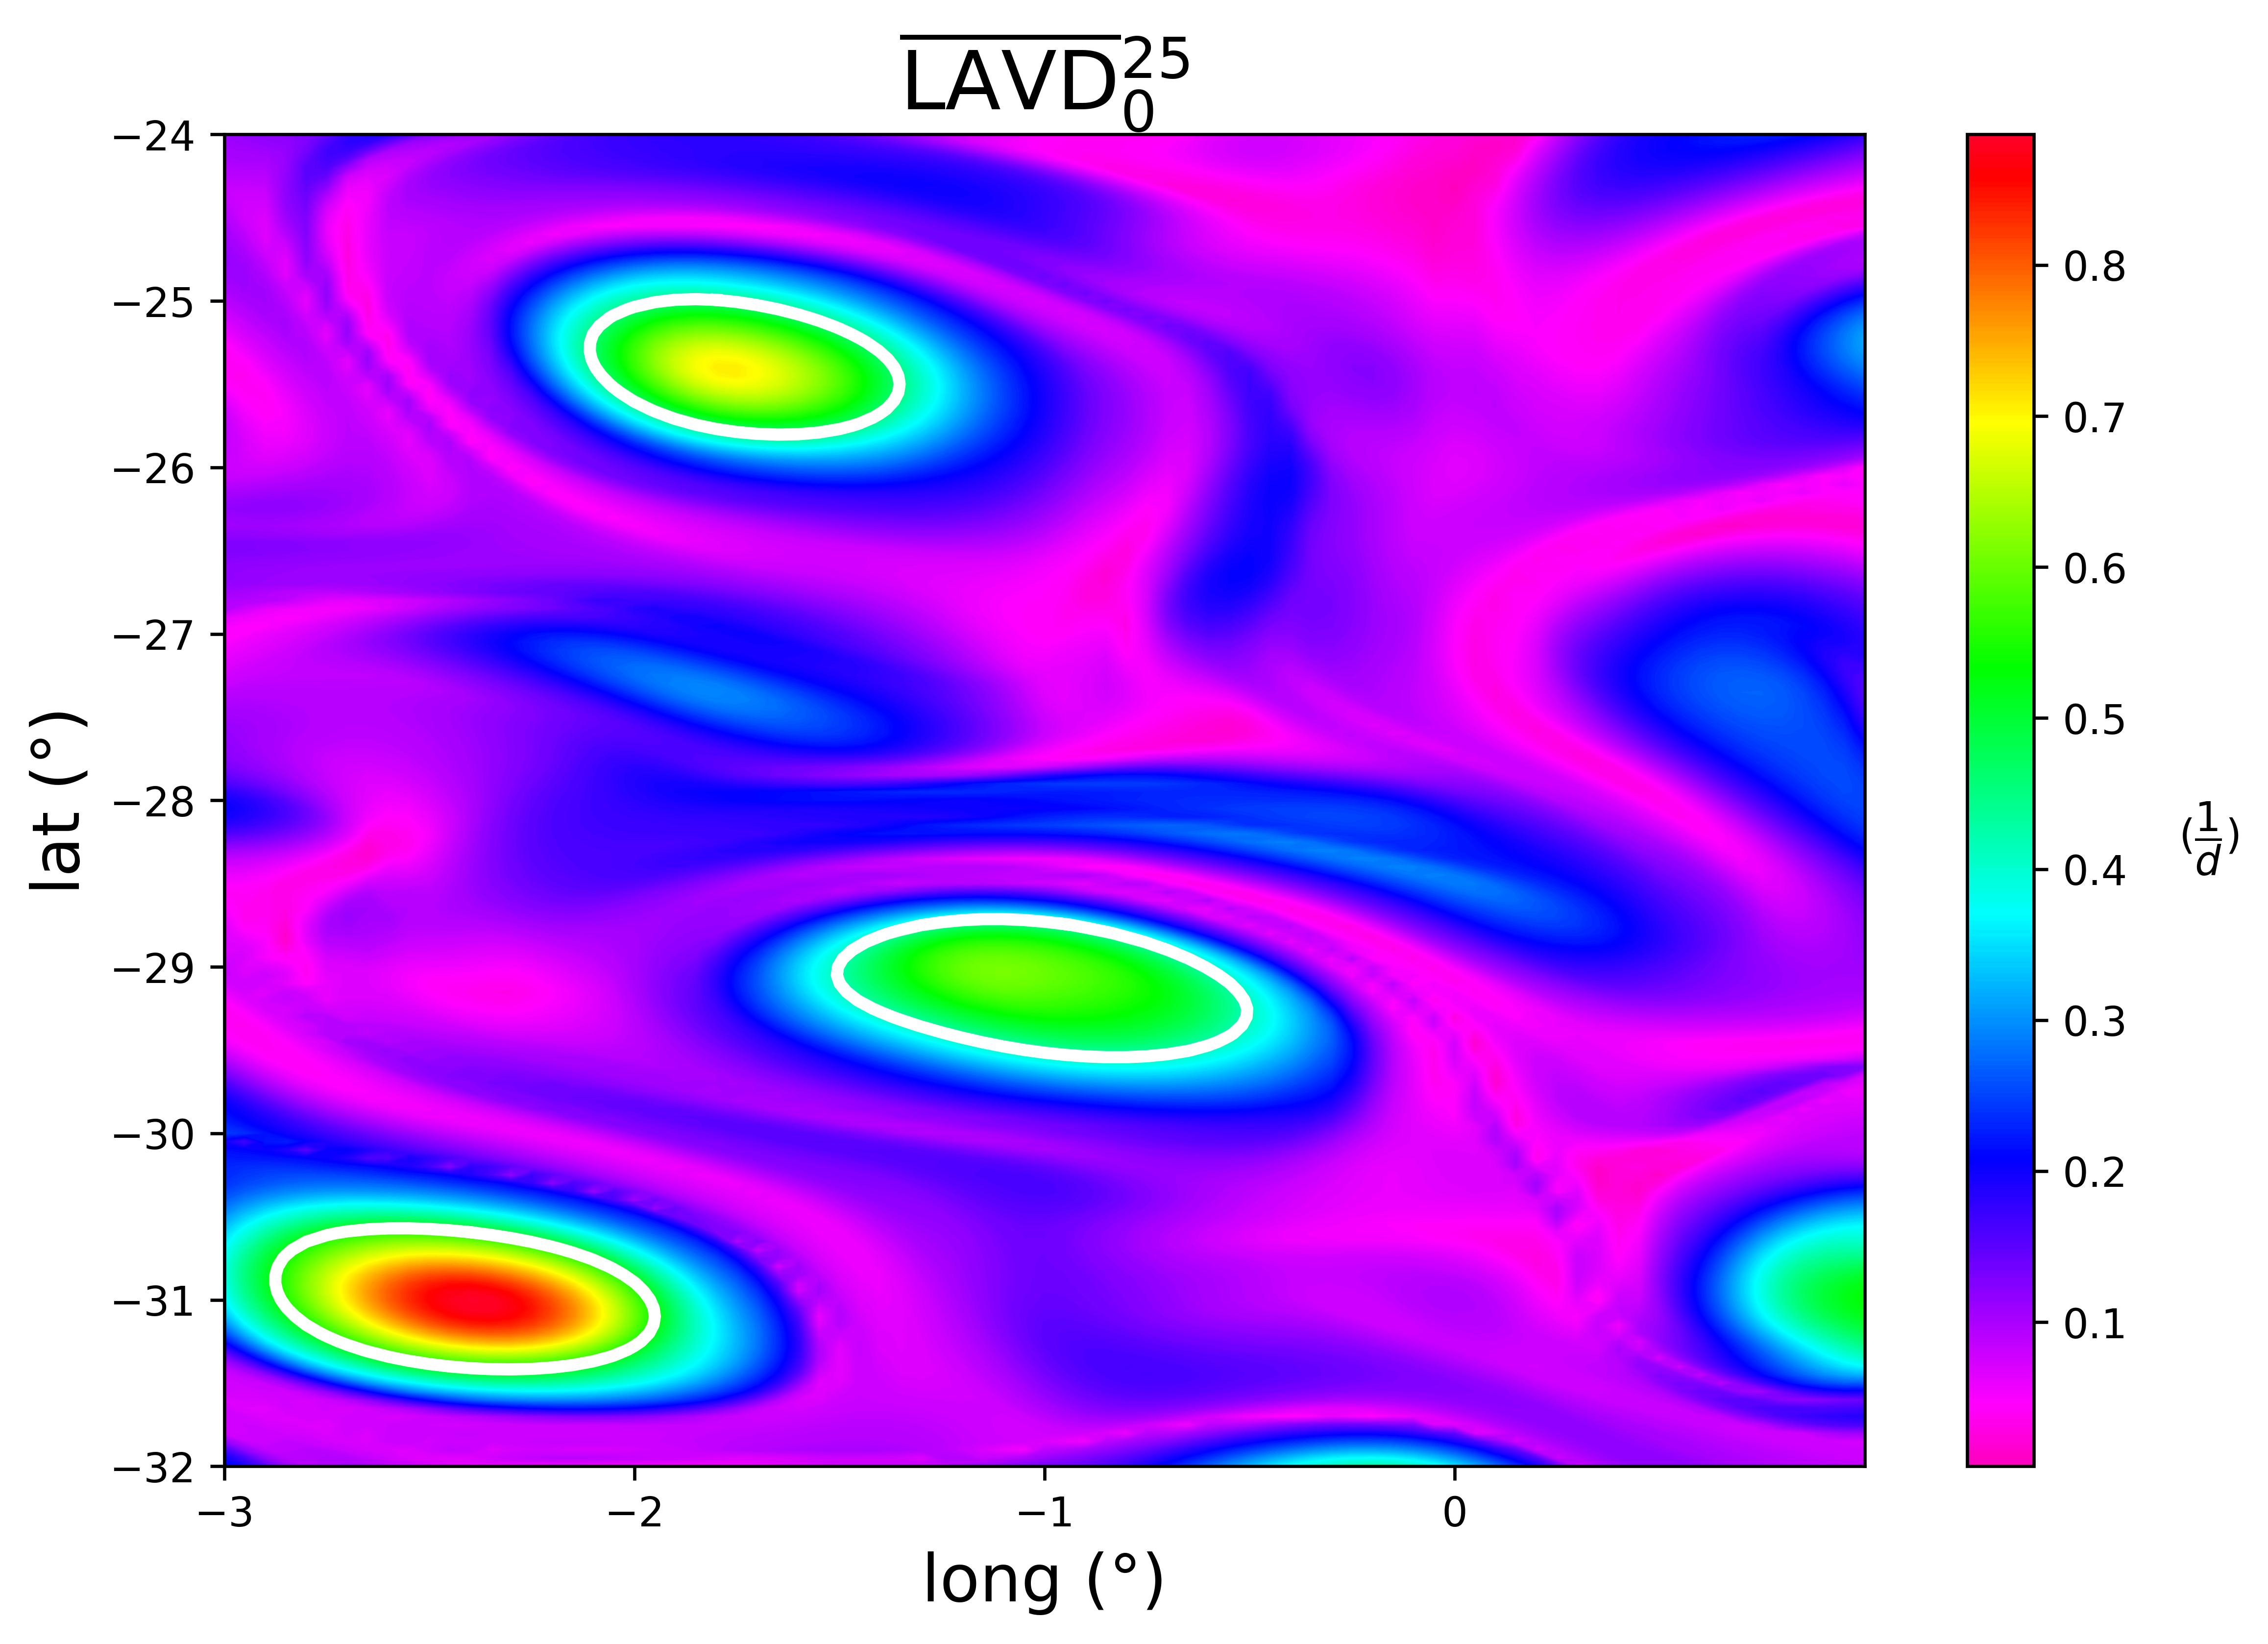

In [8]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(9, 6), dpi = 600)
ax = plt.axes()

# Contourplot of LAVD over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, LAVD, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# plot vortex boundaries
for v in vortex:
    ax.plot(v[0], v[1], c = "w", linestyle = "solid", linewidth = 3)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(-2, 2, 0.1))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 20, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{\overline{LAVD}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()

Vortical flow regions are identified as closed level curves around local extrema of the $ \mathrm{LAVD} $ satisfying specific conditions. The closed white lines indicate the identified vortex boundaries. The elliptic LCSs are clearly visible as concentric closed contours of the $ \mathrm{LAVD} $ at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{LAVD} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [Trajectory Rotation Average](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/TRA/Main/TRAAgulhas.ipynb), the [EllipticLCS](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/EllipticLCS/Main/EllipticLCSAgulhas.ipynb) or the [PRA](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/PRA/Main/PRAAgulhas.ipynb).

# References

[1] Haller, G., Hadjighasem, A., Farazmand, M., & Huhn, F. (2016). Defining coherent vortices objectively from the vorticity. Journal of Fluid Mechanics, 795, 136-173.